## Jupyter notebook for CHi-C data quality check

This notebook is the code for comparing the CHi-C data used in paper **"Burren, O.S. et al, Chromosome contacts in activated T cells identify autoimmune disease candidate genes, Genome Biology, 18 (165) (2017) "** with the 
time course CHi-C data used in the paper **"Simultaneous analysis of open chromatin, promoter interactions and gene expression in stimulated T cells implicates causal genes for rheumatoid arthritis"** by Jing Yang, Amanda McGovern, Paul Martin, Kate Duffus, Xiangyu Ge, Peyman Zarrineh, Andrew P Morris, Antony Adamson, Peter Fraser, Magnus Rattray & Stephen Eyre 

Author : *Jing Yang*  <br />
Date: 24-10-2019 <br />
For any questions about the code, please drop me a line at Jing.Yang@manchester.ac.uk

### load required libraries

In [1]:
library(ggplot2)
library(reshape2)
library(ggpol)
#library(tidyverse)

### load data

In [2]:
data_original <- read.table("https://personalpages.manchester.ac.uk/staff/jing.yang/Data/CHiC/data/CHiC_rawdata_withscore.txt", header=TRUE)

### load bait info, to include those bait-to-bait interactions twice with either baits are being used as baits or otherEnds

In [3]:
allbaitID <- read.table('https://personalpages.manchester.ac.uk/staff/jing.yang/Data/CHiC/data/baitID.txt')
data_original$baitornot <- lapply(seq(dim(data_original)[1]), function(i) sum(data_original$otherEndID[i]==allbaitID))

In [4]:
tmp <- data_original[data_original$baitornot=='1',c(2,1,3:21)]
names(tmp) <- names(data_original)
data <- unique(rbind(data_original, tmp))

### add bait and otherEnd coordinates info

In [5]:
bait_info <- read.table('https://personalpages.manchester.ac.uk/staff/jing.yang/Data/CHiC/data/capture.rmap')
names(bait_info) <- c('baitchr','baitstart','baitend','baitID')
otherEnd_info <- bait_info
names(otherEnd_info) <- c('otherEndchr','otherEndstart','otherEndend','otherEndID')

In [6]:
chic_data <- unique(merge(merge(data, bait_info), otherEnd_info))

In [7]:
dim(chic_data)

[1] 277222     27

In [8]:
cat("There are", dim(chic_data)[1], "interactions with at least one time point with Chicago score over 5")

There are 277222 interactions with at least one time point with Chicago score over 5

### retrieve merged interactions at time 0 and time 4hrs

In [9]:
idxT01_1 <- chic_data$T01_s > 5
idxT01_2 <- chic_data$T02_s > 5
idxT01 <- idxT01_1 | idxT01_2

idxT4H_1 <- chic_data$T4H1_s > 5
idxT4H_2 <- chic_data$T4H2_s > 5
idxT4H <- idxT4H_1 | idxT4H_2

idx_combined <- idxT01 | idxT4H

In [10]:
head(idx_combined)

[1] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE

In [11]:
chic_dataonly <- unique(chic_data[idx_combined,c('baitID','otherEndID','T01','T02','T201','T202','T1H1','T1H2','T4H1','T4H2','T24H1')])


### convert the coordinates from GRCh38 to GRCh37

In [12]:
coordinate_convert <- read.table('https://personalpages.manchester.ac.uk/staff/jing.yang/Data/CHiC/data/corrdinate_convert_from38to37_withbaitID.txt', header=T)
coordinate_convert_otherEnd <- read.table('https://personalpages.manchester.ac.uk/staff/jing.yang/Data/CHiC/data/corrdinate_convert_from38to37_withotherEndID.txt', header=T)

In [13]:

captureinfo <- coordinate_convert[,c(1,5,6,7)]
captureinfo_otherEnd <- coordinate_convert_otherEnd[,c(1,5,6,7)]

In [14]:
chic_data37 <- unique(merge(merge(chic_dataonly,captureinfo), captureinfo_otherEnd))


### add gene data associated with each bait

In [15]:
bait_gene_original <- read.table("https://personalpages.manchester.ac.uk/staff/jing.yang/Data/CHiC/data/baits+ENSG_final_uniq_orderedbysequence.txt", header=FALSE)
names(bait_gene_original)[1:5] <- c('baitID','chr','baitstart','baitend','ENSG')
bait_gene <- bait_gene_original[c(1,5)]

In [16]:
chic_data37_withgene <- unique(merge(chic_data37, bait_gene))

In [17]:
chic_data37_withgene_sorted <- chic_data37_withgene[with(chic_data37_withgene, order(baitID,otherEndID)), ]



### load CHi-C data from Burren at al paper

In [18]:
chic_data_fromGenomeBiology <- read.table('https://personalpages.manchester.ac.uk/staff/jing.yang/Data/CHiC/data/chic_counts_fromGenomeBiology.txt', header=T)

### prepare data for comparison

In [19]:
chic_original_forcompare <- chic_data37_withgene_sorted[,c('baitID','baitchr_37','baitstart_37','baitend_37','otherEndID','otherEndchr_37','otherEndstart_37','otherEndend_37','ENSG')]

chic_GenomeBiology_forcompare <- chic_data_fromGenomeBiology[,c('baitID','baitChr','baitStart','baitLength','oeID','oeChr','oeStart','oeLength','id')]
chic_GenomeBiology_forcompare$baitEnd <- chic_GenomeBiology_forcompare$baitStart + chic_GenomeBiology_forcompare$baitLength -1
chic_GenomeBiology_forcompare$oeEnd <- chic_GenomeBiology_forcompare$oeStart + chic_GenomeBiology_forcompare$oeLength -1


In [20]:
aa_bait <- unique(chic_original_forcompare[,c('baitchr_37','baitstart_37','baitend_37')])
bb_bait <- unique(chic_GenomeBiology_forcompare[,c('baitChr','baitStart','baitLength')])
aa_bait$label <- 'original'
bb_bait$label <- 'GB'
bb_bait$baitEnd <- (bb_bait$baitStart + bb_bait$baitLength -1)
cc_bait <- bb_bait[,c('baitChr','baitStart','baitEnd','label')]
names(aa_bait) <- names(cc_bait)
combined_bait <- rbind(aa_bait, cc_bait)
combined_bait_sorted <- combined_bait[with(combined_bait, order(baitChr, baitStart)),]
tmp <- sapply(1:(dim(combined_bait_sorted)[1]-1), function(i) combined_bait_sorted$baitStart[i+1]-combined_bait_sorted$baitStart[i])
bait_GB_intersect <- combined_bait_sorted[(which(tmp==1)+1),c('baitChr','baitStart')]    
bait_original_intersect <- combined_bait_sorted[which(tmp==1),c('baitChr','baitStart')]
names(bait_original_intersect) <- c('baitchr_37','baitstart_37')
tmp_original <- merge(chic_original_forcompare, bait_original_intersect)
tmp_GB <- merge(chic_GenomeBiology_forcompare, bait_GB_intersect)
chic_original_forcompare <- tmp_original
chic_GenomeBiology_forcompare <- tmp_GB

In [21]:
aa_oe <- unique(chic_original_forcompare[,c('otherEndchr_37','otherEndstart_37','otherEndend_37')])
bb_oe <- unique(chic_GenomeBiology_forcompare[,c('oeChr','oeStart','oeLength')])
aa_oe$label <- 'original'
bb_oe$label <- 'GB'
bb_oe$oeEnd <- (bb_oe$oeStart + bb_oe$oeLength -1)
cc_oe <- bb_oe[,c('oeChr','oeStart','oeEnd','label')]
names(aa_oe) <- names(cc_oe)
combined_oe <- rbind(aa_oe, cc_oe)
combined_oe_sorted <- combined_oe[with(combined_oe, order(oeChr, oeStart)),]
tmp <- sapply(1:(dim(combined_oe_sorted)[1]-1), function(i) combined_oe_sorted$oeStart[i+1]-combined_oe_sorted$oeStart[i])
oe_GB_intersect <- combined_oe_sorted[(which(tmp==1)+1),c('oeChr','oeStart')]    
oe_original_intersect <- combined_oe_sorted[which(tmp==1),c('oeChr','oeStart')]
names(oe_original_intersect) <- c('otherEndchr_37','otherEndstart_37')
tmp_original <- merge(chic_original_forcompare, oe_original_intersect)
tmp_GB <- merge(chic_GenomeBiology_forcompare, oe_GB_intersect)
chic_original_forcompare <- tmp_original
chic_GenomeBiology_forcompare <- tmp_GB

### Due to mapped to different reference genome, interactions of distance with 2 bp are deemed the same

In [22]:

chic_original_forcompare$baitpos <- 0.5*(chic_original_forcompare$baitstart_37+chic_original_forcompare$baitend_37) 
chic_original_forcompare$otherEndpos <- 0.5*(chic_original_forcompare$otherEndstart_37+chic_original_forcompare$otherEndend_37)
chic_GenomeBiology_forcompare$baitpos <- 0.5*(chic_GenomeBiology_forcompare$baitStart+chic_GenomeBiology_forcompare$baitStart + chic_GenomeBiology_forcompare$baitLength) 
chic_GenomeBiology_forcompare$oepos <- 0.5*(chic_GenomeBiology_forcompare$oeStart+chic_GenomeBiology_forcompare$oeStart+chic_GenomeBiology_forcompare$oeLength)

chic_original_forcompare$dist <- abs(chic_original_forcompare$baitpos - chic_original_forcompare$otherEndpos)
chic_original_forcompare$pos <- 0.5*(chic_original_forcompare$baitpos + chic_original_forcompare$otherEndpos)

chic_GenomeBiology_forcompare$dist <- abs(chic_GenomeBiology_forcompare$baitpos - chic_GenomeBiology_forcompare$oepos)
chic_GenomeBiology_forcompare$pos <- 0.5*(chic_GenomeBiology_forcompare$baitpos + chic_GenomeBiology_forcompare$oepos)

idx_5M_original <- chic_original_forcompare$dist<5000000
idx_5M_GB <- chic_GenomeBiology_forcompare$dist<5000000

idx_1M_original <- chic_original_forcompare$dist<1000000
idx_1M_GB <- chic_GenomeBiology_forcompare$dist<1000000

idx_500K_original <- chic_original_forcompare$dist<500000
idx_500K_GB <- chic_GenomeBiology_forcompare$dist<500000

idx_200K_original <- chic_original_forcompare$dist<200000
idx_200K_GB <- chic_GenomeBiology_forcompare$dist<200000

M <- 2
sum_interaction_2 <- list()
data_original <- unique(chic_original_forcompare[,c('baitchr_37','pos','baitstart_37')])
data_GenomeBiology <- unique(chic_GenomeBiology_forcompare[,c('baitChr','pos','baitStart')])
names(data_original) <- c('chr','pos','start')
data_original$label <- 'original'
names(data_GenomeBiology) <- c('chr','pos','start')
data_GenomeBiology$label <- 'GB'
data_combined <- rbind(data_original, data_GenomeBiology)
data_combined_sorted <- data_combined[with(data_combined, order(chr,pos,start)),]
sum_interaction <- 0
for (ii in 2:(dim(data_combined_sorted)[1]-1)){
    if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii-1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii-1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii-1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii+1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii+1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii+1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else {}
    
    
}
sum_interaction_2 <- c(sum_interaction_2, sum_interaction)
cat('There are ', dim(data_original)[1], ' and ', dim(data_GenomeBiology)[1], ' interactions in original and GB data, among them the intersected are ')
print(sum_interaction)


data_original <- unique(chic_original_forcompare[idx_5M_original,c('baitchr_37','pos','baitstart_37')])
data_GenomeBiology <- unique(chic_GenomeBiology_forcompare[idx_5M_GB,c('baitChr','pos','baitStart')])
names(data_original) <- c('chr','pos','start')
data_original$label <- 'original'
names(data_GenomeBiology) <- c('chr','pos','start')
data_GenomeBiology$label <- 'GB'
data_combined <- rbind(data_original, data_GenomeBiology)
data_combined_sorted <- data_combined[with(data_combined, order(chr,pos)),]
sum_interaction <- 0
for (ii in 2:(dim(data_combined_sorted)[1]-1)){
    if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii-1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii-1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii-1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii+1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii+1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii+1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else {}
    
    
}
sum_interaction_2 <- c(sum_interaction_2, sum_interaction)
cat('There are ', dim(data_original)[1], ' and ', dim(data_GenomeBiology)[1], ' interactions in original and GB data (<5MB) , among them the intersected are ')
print(sum_interaction)

data_original <- unique(chic_original_forcompare[idx_1M_original,c('baitchr_37','pos','baitstart_37')])
data_GenomeBiology <- unique(chic_GenomeBiology_forcompare[idx_1M_GB,c('baitChr','pos','baitStart')])
names(data_original) <- c('chr','pos','start')
data_original$label <- 'original'
names(data_GenomeBiology) <- c('chr','pos','start')
data_GenomeBiology$label <- 'GB'
data_combined <- rbind(data_original, data_GenomeBiology)
data_combined_sorted <- data_combined[with(data_combined, order(chr,pos)),]
sum_interaction <- 0
for (ii in 2:(dim(data_combined_sorted)[1]-1)){
    if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii-1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii-1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii-1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii+1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii+1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii+1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else {}
    
    
}
sum_interaction_2 <- c(sum_interaction_2, sum_interaction)

cat('There are ', dim(data_original)[1], ' and ', dim(data_GenomeBiology)[1], ' interactions in original and GB data (<1MB), among them the intersected are ')
print(sum_interaction)


data_original <- unique(chic_original_forcompare[idx_500K_original,c('baitchr_37','pos','baitstart_37')])
data_GenomeBiology <- unique(chic_GenomeBiology_forcompare[idx_500K_GB,c('baitChr','pos','baitStart')])
names(data_original) <- c('chr','pos','start')
data_original$label <- 'original'
names(data_GenomeBiology) <- c('chr','pos','start')
data_GenomeBiology$label <- 'GB'
data_combined <- rbind(data_original, data_GenomeBiology)
data_combined_sorted <- data_combined[with(data_combined, order(chr,pos)),]
sum_interaction <- 0
for (ii in 2:(dim(data_combined_sorted)[1]-1)){
    if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii-1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii-1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii-1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii+1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii+1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii+1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else {}
    
    
}
sum_interaction_2 <- c(sum_interaction_2, sum_interaction)

cat('There are ', dim(data_original)[1], ' and ', dim(data_GenomeBiology)[1], ' interactions in original and GB data (<500k), among them the intersected are ')
print(sum_interaction)


data_original <- unique(chic_original_forcompare[idx_200K_original,c('baitchr_37','pos','baitstart_37')])
data_GenomeBiology <- unique(chic_GenomeBiology_forcompare[idx_200K_GB,c('baitChr','pos','baitStart')])
names(data_original) <- c('chr','pos','start')
data_original$label <- 'original'
names(data_GenomeBiology) <- c('chr','pos','start')
data_GenomeBiology$label <- 'GB'
data_combined <- rbind(data_original, data_GenomeBiology)
data_combined_sorted <- data_combined[with(data_combined, order(chr,pos)),]
sum_interaction <- 0
for (ii in 2:(dim(data_combined_sorted)[1]-1)){
    #print(ii)
    if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii-1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii-1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii-1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else if ((data_combined_sorted$label[ii] == 'original') &
        (data_combined_sorted$label[ii] != data_combined_sorted$label[ii+1]) & 
        (abs(data_combined_sorted$pos[ii]-data_combined_sorted$pos[ii+1])<M) &
        (abs(data_combined_sorted$start[ii]-data_combined_sorted$start[ii+1])<M)) {
        sum_interaction <- sum_interaction +1
    }
    else {}
    
    
}
sum_interaction_2 <- c(sum_interaction_2, sum_interaction)

cat('There are ', dim(data_original)[1], ' and ', dim(data_GenomeBiology)[1], ' interactions in original and GB data (<200k), among them the intersected are ')
print(sum_interaction)


There are  48570  and  43345  interactions in original and GB data, among them the intersected are [1] 27794
There are  36698  and  40882  interactions in original and GB data (<5MB) , among them the intersected are [1] 26836
There are  28028  and  34539  interactions in original and GB data (<1MB), among them the intersected are [1] 22554
There are  21481  and  27588  interactions in original and GB data (<500k), among them the intersected are [1] 17986
There are  9627  and  13464  interactions in original and GB data (<200k), among them the intersected are [1] 8367


### plot venn diagram

In [23]:
data_venn <- data.frame(intersect=c(27794,26836,22554,17986,8367), 
                        original_in_our=c(48570, 36698, 28028, 21481, 9627),
                        original_in_1=c(43345,40882,34539,27588,13464))
data_venn$uniq_in_our <- data_venn$original_in_our-data_venn$intersect
data_venn$uniq_in_1 <- data_venn$original_in_1-data_venn$intersect

In [24]:
df.venn0 <- data.frame(x = c(0, data_venn$uniq_in_our[1]/(data_venn$intersect[1]+data_venn$uniq_in_our[1])),
                      y = c(1, 1))
df.venn2 <- data.frame(x = c(2, 1.2+data_venn$uniq_in_our[1]/(data_venn$intersect[1]+data_venn$uniq_in_our[1])),
                      y = c(1, 1))
df.venn1 <- data.frame(x = c(0, data_venn$uniq_in_our[1]/(data_venn$intersect[1]+data_venn$uniq_in_our[1])),
                      y = c(2.2, 2.2))
df.venn4 <- data.frame(x = c(2, 1.2+data_venn$uniq_in_our[1]/(data_venn$intersect[1]+data_venn$uniq_in_our[1])),
                      y = c(2.2, 2.2))
df.venn3 <- data.frame(x = c(0, data_venn$uniq_in_our[1]/(data_venn$intersect[1]+data_venn$uniq_in_our[1])),
                      y = c(3.5, 3.5))



df.venn <- rbind(df.venn0, df.venn1, df.venn2, df.venn3, df.venn4) 
df.venn$label1 <- rep(c('All','<5Mb','<500kb','<1Mb','<200kb'), each=2)
df.venn$label2 <- c(rep(c('Our Data','Data from Burren et al'), 2), 
                    c('Data from Burren et al','Our Data','Our Data','Data from Burren et al',
                      'Data from Burren et al','Our Data'))
df.venn$label1 <- factor(df.venn$label1, levels=c('All','<5Mb','<1Mb','<500kb','<200kb'))

In [25]:
data_venn[,c('uniq_in_our','intersect','uniq_in_1')]

uniq_in_our,intersect,uniq_in_1
<dbl>,<dbl>,<dbl>
20776,27794,15551
9862,26836,14046
5474,22554,11985
3495,17986,9602
1260,8367,5097


In [26]:
c(unlist(t(data_venn[,c('uniq_in_our','intersect','uniq_in_1')])))

[1] 20776 27794 15551  9862 26836 14046  5474 22554 11985  3495 17986  9602
[13]  1260  8367  5097

In [27]:
data_venn

intersect,original_in_our,original_in_1,uniq_in_our,uniq_in_1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27794,48570,43345,20776,15551
26836,36698,40882,9862,14046
22554,28028,34539,5474,11985
17986,21481,27588,3495,9602
8367,9627,13464,1260,5097


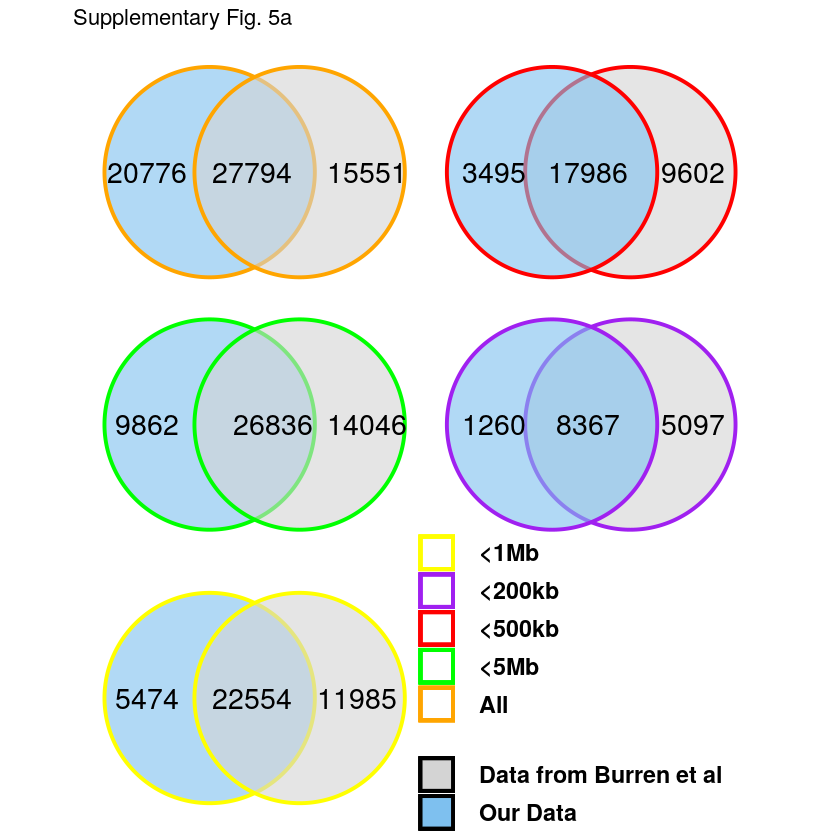

In [29]:
df.label <- data.frame(x=c(-0.1, 0.4, 0.95, -0.1, 0.5,0.95,  -0.1, 0.4, 0.9, 1.55, 2.0, 2.5, 1.55, 2.0, 2.5)-0.2, 
                       y=c(0.0, 0.0, 0.0, 1.2, 1.2, 1.2, 2.5, 2.5, 2.5, 0.0,0.0,0.0, 1.2, 1.2, 1.2)+1.0,
                       Counts=c(unlist(t(data_venn[,c('uniq_in_our','intersect','uniq_in_1')]))))
ggplot() +
  geom_circle(data=df.venn[1:2,], aes(x = x, y = -y, r = 0.5, color = label1, fill=label2), alpha = .6, size = 1.1) +
  geom_circle(data=df.venn[3:4,], aes(x = x, y = -y, r = 0.5, color = label1, fill=label2), alpha = .6, size = 1.1) +
  geom_circle(data=df.venn[5:6,], aes(x = x, y = -y, r = 0.5, color = label1, fill=label2), alpha = .6, size = 1.1) +
  geom_circle(data=df.venn[7:8,], aes(x = x, y = -y, r = 0.5, color = label1, fill=label2), alpha = .6, size = 1.1) +
  geom_circle(data=df.venn[9:10,], aes(x = x, y = -y, r = 0.5, color = label1, fill=label2), alpha = .6, size = 1.1) +
  
  coord_fixed() +
  theme_void() +
  theme(legend.position = c(0.72,0.2), legend.text = element_text(size=14, face='bold'),
      legend.key.size = unit(0.8, "cm"), legend.spacing.x = unit(0.5, 'cm'), legend.title=element_blank()) +
  scale_color_manual(values=c('All'='orange','<5Mb'='green','<1Mb'='yellow','<500kb'='red','<200kb'='purple'))+
  #scale_linetype_manual(labels=c('All','<5Mb','<1Mb','<500kb','<200kb'), 
  #                   values = c('All'=2,'<5Mb'=2, '<1Mb'=2,'<500kb'=2,'<200kb'=2)) +
  scale_fill_manual(values=c('lightgrey','skyblue2')) +
  annotate("text", x = df.label$x, y = -df.label$y, label = df.label$Counts, size = 6) +
  #scale_fill_manual(values = c('cornflowerblue', 'firebrick',  'gold')) +
  #scale_colour_manual(values = c('cornflowerblue', 'firebrick', 'gold'), guide = FALSE) +
  labs(fill=NULL) + guides(fill=guide_legend(nrow=2,title='')) + ggtitle('Supplementary Fig. 5a')
  #annotate("text", x = df.vdc$x, y = df.vdc$y, label = df.vdc)
#ggsave('../../../IntegratingATAC-RNA-HiC/Individual_Figures_Files/CHiC_quality_check/CHiC_quality_check_0210.pdf')